<a href="https://colab.research.google.com/github/mohmmadhadi/MarketingLab/blob/main/Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [ ]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx


#Data Preprocessing

In [ ]:
# Load the dataset
data = pd.read_csv('marketing_attribution.csv')

<ipython-input-2-f1c68a01f1e9>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('marketing_attribution.csv')


In [ ]:
# Convert visitStartTime to datetime
data['visitStartTime'] = pd.to_datetime(data['visitStartTime'], unit='s')

# Sort the data by fullVisitorId and visitStartTime
data = data.sort_values(by=['fullVisitorId', 'visitStartTime'])

##Define Attribution Window

In [ ]:
def apply_attribution_window(data, window_days=30):
    data['conversion_date'] = data.groupby('fullVisitorId')['visitStartTime'].transform(lambda x: x.max())
    data['within_window'] = (data['conversion_date'] - data['visitStartTime']) <= timedelta(days=window_days)
    return data[data['within_window']]

In [ ]:
data_within_window = apply_attribution_window(data)

In [ ]:
data_within_window

,fullVisitorId,date,visitId,visitStartTime,channelGrouping,utm_source,utm_medium,transactionRevenue,transactionId,conversion_date,within_window
697997,4823595352351,2016-11-01,1478011510,2016-11-01 14:45:10,Organic Search,baidu,organic,NaN,NaN,2016-11-01 14:45:10,True
349569,5103959234087,2016-08-21,1471817208,2016-08-21 22:06:48,Organic Search,google,organic,NaN,NaN,2016-08-21 22:06:48,True
626999,10278554503158,2016-10-20,1477029466,2016-10-21 05:57:46,Organic Search,google,organic,NaN,NaN,2016-10-21 05:57:46,True
849861,20424342248747,2016-11-30,1480578901,2016-12-01 07:55:01,Organic Search,(direct),(none),NaN,NaN,2016-12-01 07:55:01,True
493278,26722803385797,2017-06-05,1496658394,2017-06-05 10:26:34,Organic Search,google,organic,NaN,NaN,2017-06-05 10:26:34,True
...,...,...,...,...,...,...,...,...,...,...,...
761619,9999379202747789695,2017-07-25,1501026882,2017-07-25 23:54:42,Organic Search,google,organic,NaN,NaN,2017-07-25 23:54:42,True
10171,9999392014132444631,2016-12-20,1482265962,2016-12-20 20:32:42,Organic Search,(direct),(none),NaN,NaN,2016-12-20 20:32:42,True
761403,9999430912254902219,2017-07-25,1500972450,2017-07-25 08:47:30,Organic Search,google,organic,NaN,NaN,2017-07-25 08:47:30,True
741030,9999509706819567356,2016-11-08,1478658936,2016-11-09 02:35:36,Organic Search,(direct),(none),NaN,NaN,2016-11-09 02:35:36,True


#Last Click Attribution Model

##Model

In [ ]:
last_click_attribution = data_within_window.drop_duplicates(subset=['transactionId'], keep='last')
last_click_attribution_summary = last_click_attribution.groupby('channelGrouping')['transactionRevenue'].sum()

##Visualization

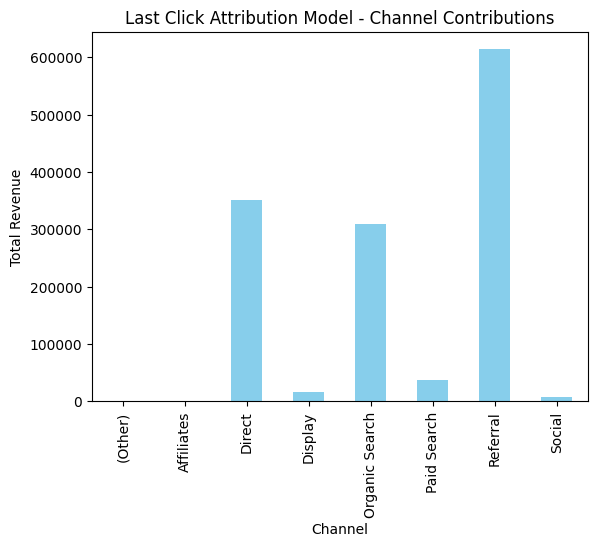

In [ ]:
last_click_attribution_summary.plot(kind='bar', color='skyblue')
plt.title('Last Click Attribution Model - Channel Contributions')
plt.xlabel('Channel')
plt.ylabel('Total Revenue')
plt.show()

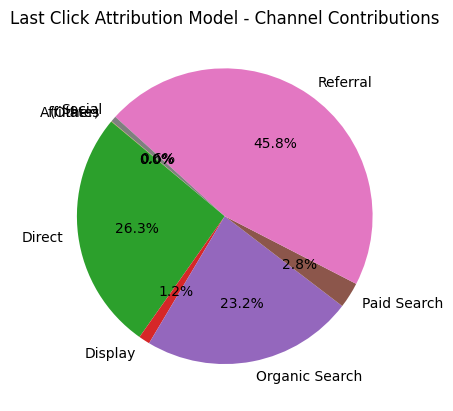

In [ ]:
last_click_attribution_summary.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Last Click Attribution Model - Channel Contributions')
plt.ylabel('')
plt.show()

#Data Driven Attribution Model (Markov Chains)

##Model

In [ ]:
# Encode channels
le = LabelEncoder()
data_within_window['channel'] = le.fit_transform(data_within_window['channelGrouping'])

<ipython-input-10-b7971f68056e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_window['channel'] = le.fit_transform(data_within_window['channelGrouping'])


In [ ]:
# Create Transition Matrix
n_channels = len(le.classes_)
transition_matrix = np.zeros((n_channels, n_channels))

for visitor_id, group in data_within_window.groupby('fullVisitorId'):
    channels = group['channel'].values
    for i in range(len(channels) - 1):
        transition_matrix[channels[i], channels[i+1]] += 1

In [ ]:
# Normalize the matrix
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

In [ ]:
# Implement Markov Chain
def markov_chain_transition(matrix, start_prob, num_steps=100):
    state = start_prob
    for _ in range(num_steps):
        state = state.dot(matrix)
    return state

In [ ]:
# Initialize start probabilities (equal probability to all channels)
start_prob = np.full(n_channels, 1/n_channels)

In [ ]:
# Run Markov Chain
final_state = markov_chain_transition(transition_matrix, start_prob)

In [ ]:
# Calculate channel contributions
channel_contributions = final_state * data_within_window['transactionRevenue'].sum()
channel_contributions_summary = pd.Series(channel_contributions, index=le.classes_)

In [ ]:
final_state

array([0.00080928, 0.02397801, 0.00404172, 0.03940881, 0.42920899,
       0.04642517, 0.35352824, 0.10259978])

##Visualization

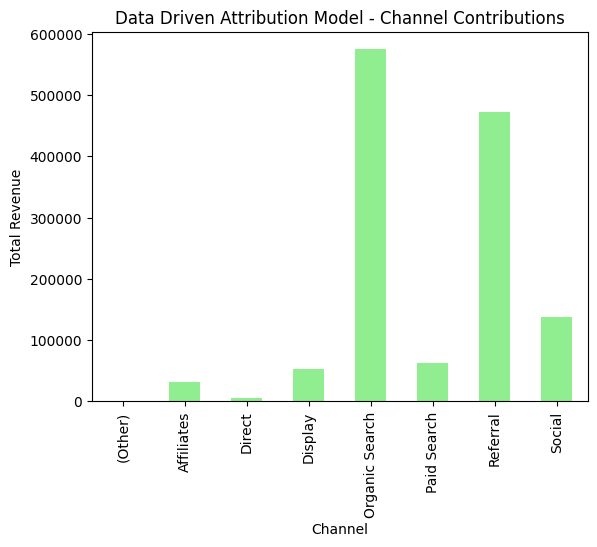

In [ ]:
channel_contributions_summary.plot(kind='bar', color='lightgreen')
plt.title('Data Driven Attribution Model - Channel Contributions')
plt.xlabel('Channel')
plt.ylabel('Total Revenue')
plt.show()

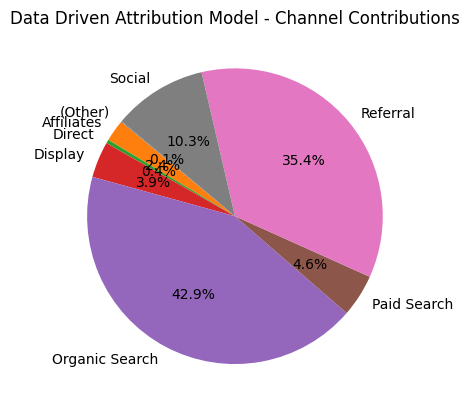

In [ ]:
channel_contributions_summary.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title('Data Driven Attribution Model - Channel Contributions')
plt.ylabel('')
plt.show()

Transition Matrix Heatmap

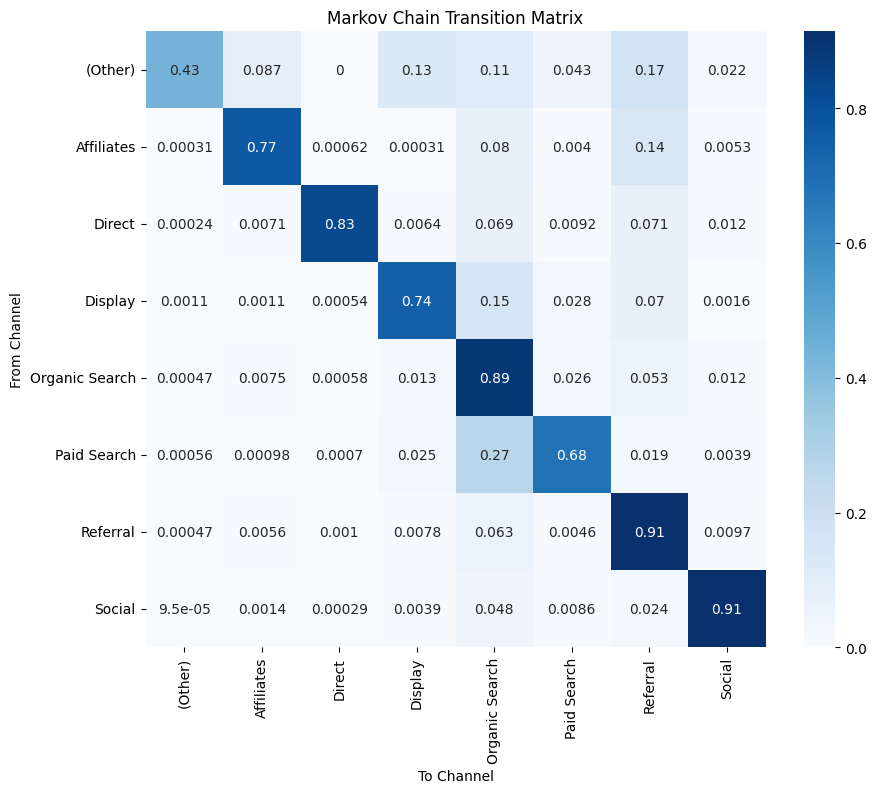

In [ ]:
# Assume transition_matrix is the normalized matrix you have computed
channel_names = le.classes_
plt.figure(figsize=(10, 8))
sns.heatmap(transition_matrix, xticklabels=channel_names, yticklabels=channel_names, annot=True, cmap='Blues')
plt.title('Markov Chain Transition Matrix')
plt.xlabel('To Channel')
plt.ylabel('From Channel')
plt.show()

Sankey Diagram

In [ ]:
import plotly.graph_objects as go

# Prepare data for Sankey diagram
source = []
target = []
value = []

for i, from_channel in enumerate(channel_names):
    for j, to_channel in enumerate(channel_names):
        if transition_matrix[i, j] > 0:
            source.append(i)
            target.append(j)
            value.append(transition_matrix[i, j])

# Define node labels
node_labels = list(channel_names)

# Create Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=source,
        target=target,
        value=value
    )
))

fig.update_layout(title_text="Markov Chain Sankey Diagram", font_size=10)
fig.show()


Flow Diagram

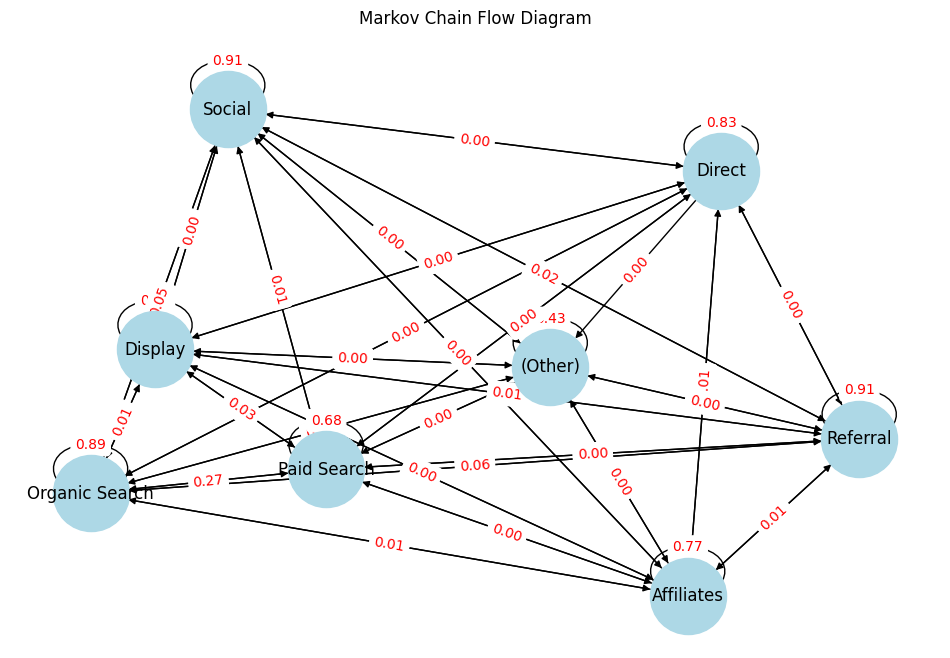

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for i, channel in enumerate(channel_names):
    G.add_node(i, label=channel)

# Add edges with weights
for i in range(len(channel_names)):
    for j in range(len(channel_names)):
        if transition_matrix[i, j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i, j])

pos = nx.spring_layout(G)

# Draw the graph
fig, ax = plt.subplots(figsize=(12, 8))
nx.draw(G, pos, ax=ax, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_size=3000, node_color='lightblue', font_size=12)
edge_labels = {(i, j): f'{transition_matrix[i, j]:.2f}' for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.title('Markov Chain Flow Diagram')
plt.show()


Transition Probability Matrix with Nodes

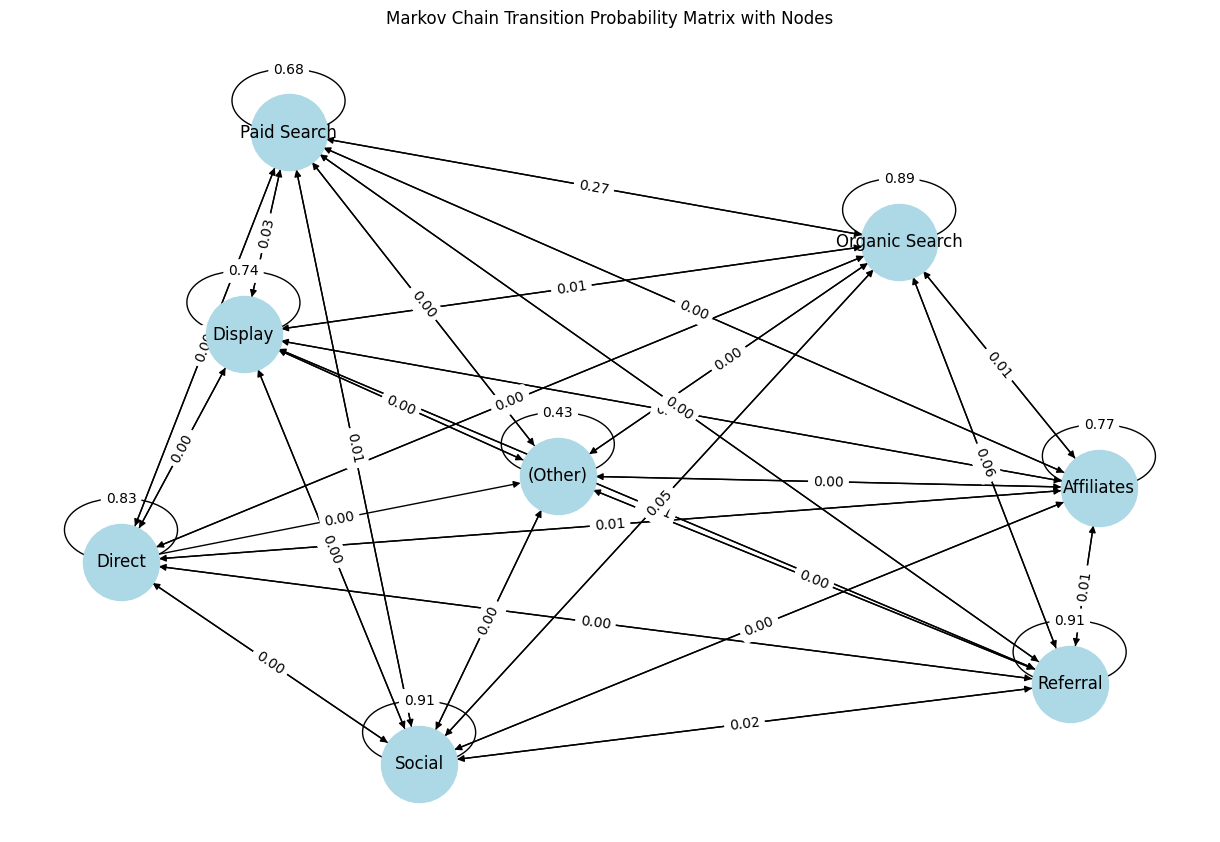

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes (channels)
for idx, channel in enumerate(channel_names):
    G.add_node(idx, label=channel)

# Add edges with weights (transition probabilities)
for i in range(len(channel_names)):
    for j in range(len(channel_names)):
        if transition_matrix[i, j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i, j])

# Draw the graph
pos = nx.spring_layout(G, seed=42)  # positions for all nodes
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, labels={i: channel for i, channel in enumerate(channel_names)}, node_size=3000, node_color='lightblue', font_size=12)
edge_labels = {(i, j): f'{transition_matrix[i, j]:.2f}' for i, j in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
plt.title('Markov Chain Transition Probability Matrix with Nodes')
plt.show()


Circle Pack Diagram

In [ ]:
import plotly.express as px

# Prepare data for circle packing
import pandas as pd

data_cp = []
for i, from_channel in enumerate(channel_names):
    for j, to_channel in enumerate(channel_names):
        if transition_matrix[i, j] > 0:
            data_cp.append({
                'from_channel': from_channel,
                'to_channel': to_channel,
                'value': transition_matrix[i, j]
            })

df_cp = pd.DataFrame(data_cp)

fig = px.sunburst(df_cp, path=['from_channel', 'to_channel'], values='value', color='value',
                  color_continuous_scale='RdBu', title='Markov Chain Circle Pack Diagram')
fig.update_layout(margin=dict(t=40, l=0, r=0, b=0))
fig.show()


#Comparison

In [ ]:
comparison = pd.DataFrame({
    'Last Click': last_click_attribution_summary,
    'Data Driven': channel_contributions_summary
}).fillna(0)

In [ ]:
comparison

,Last Click,Data Driven
(Other),11.99,1083.243204
Affiliates,654.38,32095.102939
Direct,351757.61,5409.933038
Display,16462.28,52749.575736
Organic Search,310044.98,574505.898255
Paid Search,37799.22,62141.141613
Referral,613480.65,473205.505054
Social,8311.41,137332.120161


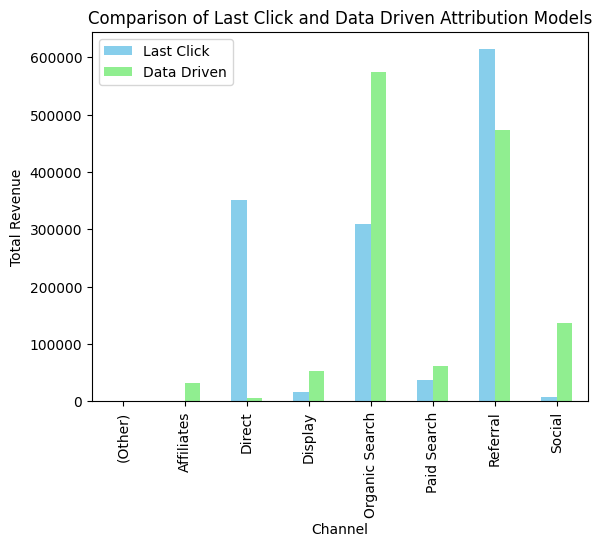

In [ ]:
comparison.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Comparison of Last Click and Data Driven Attribution Models')
plt.xlabel('Channel')
plt.ylabel('Total Revenue')
plt.legend(['Last Click', 'Data Driven'])
plt.show()

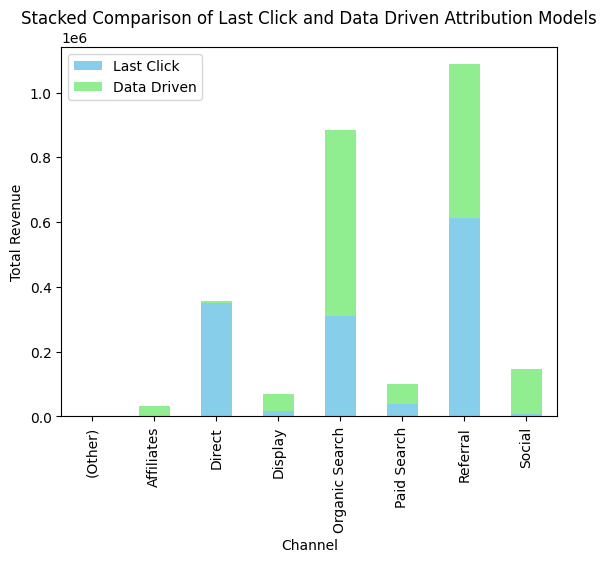

In [ ]:
comparison.plot(kind='bar', stacked=True, color=['skyblue', 'lightgreen'])
plt.title('Stacked Comparison of Last Click and Data Driven Attribution Models')
plt.xlabel('Channel')
plt.ylabel('Total Revenue')
plt.legend(['Last Click', 'Data Driven'])
plt.show()

Grouped Bar Chart

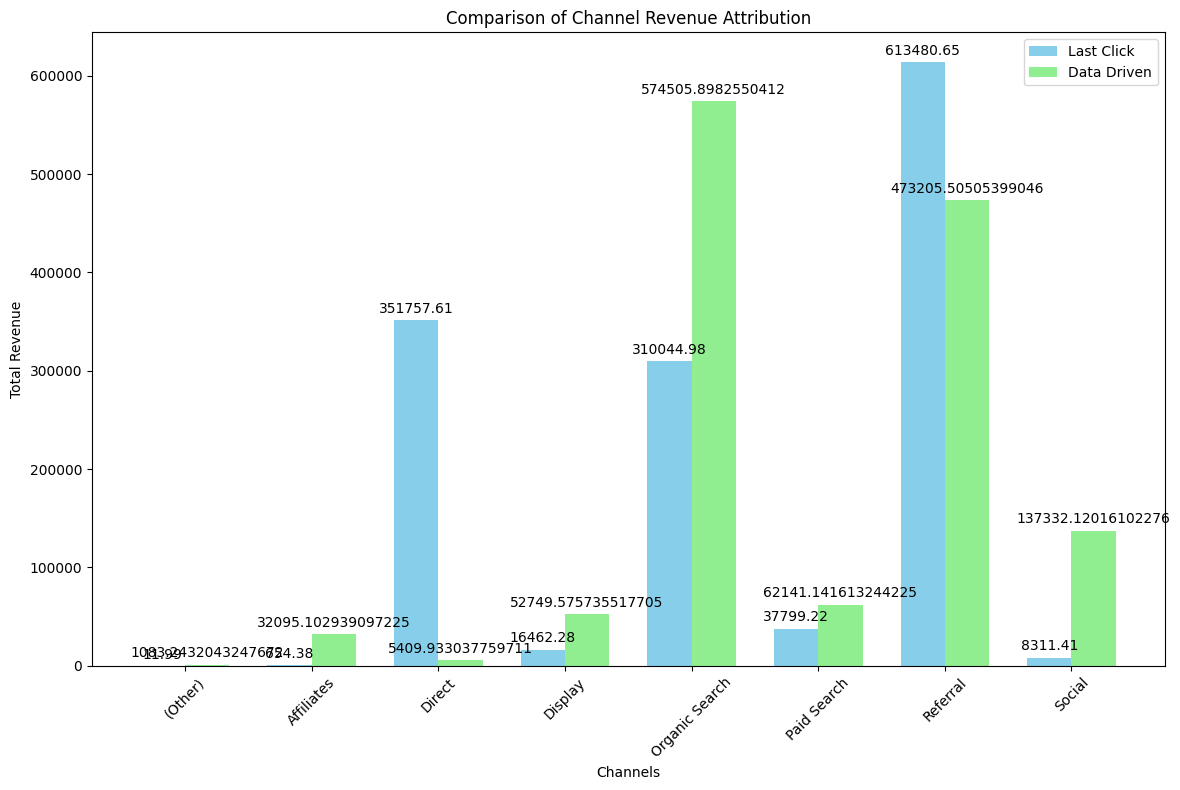

In [ ]:
# Data preparation
channels = comparison.index
last_click = comparison['Last Click']
data_driven = comparison['Data Driven']

# Plotting
x = np.arange(len(channels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.bar(x - width/2, last_click, width, label='Last Click', color='skyblue')
bars2 = ax.bar(x + width/2, data_driven, width, label='Data Driven', color='lightgreen')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Channels')
ax.set_ylabel('Total Revenue')
ax.set_title('Comparison of Channel Revenue Attribution')
ax.set_xticks(x)
ax.set_xticklabels(channels)
ax.legend()

# Add labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Radar Chart (Spider Chart)

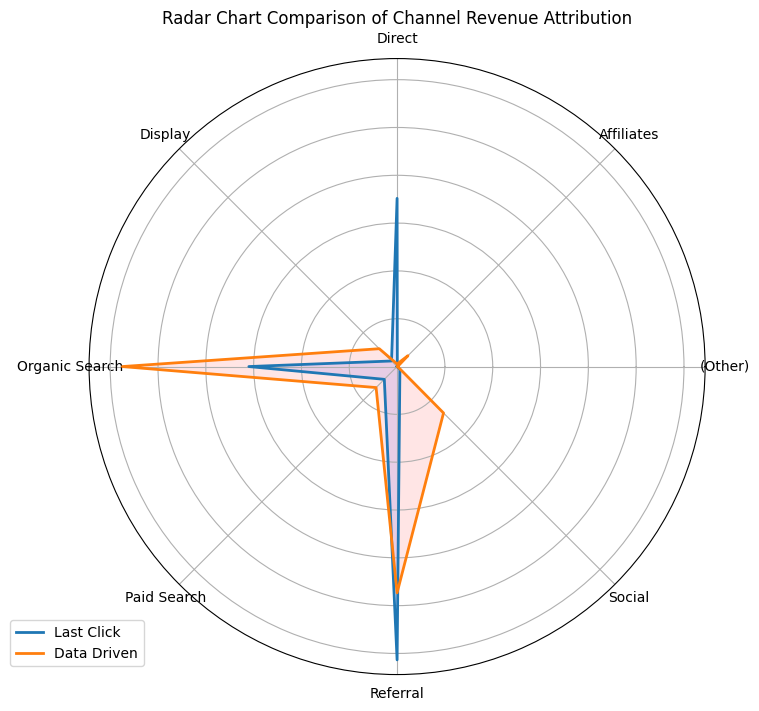

In [ ]:
from math import pi

# Data preparation
categories = comparison.index
last_click_values = comparison['Last Click'].values
data_driven_values = comparison['Data Driven'].values

# Number of variables
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Initialize the radar chart
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Add the last values to close the circle
last_click_values = np.concatenate((last_click_values, [last_click_values[0]]))
data_driven_values = np.concatenate((data_driven_values, [data_driven_values[0]]))

# Plot data
ax.plot(angles, last_click_values, linewidth=2, linestyle='solid', label='Last Click')
ax.fill(angles, last_click_values, 'b', alpha=0.1)

ax.plot(angles, data_driven_values, linewidth=2, linestyle='solid', label='Data Driven')
ax.fill(angles, data_driven_values, 'r', alpha=0.1)

# Add labels and title
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title('Radar Chart Comparison of Channel Revenue Attribution')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


Heatmap Comparison of Channel Attributions

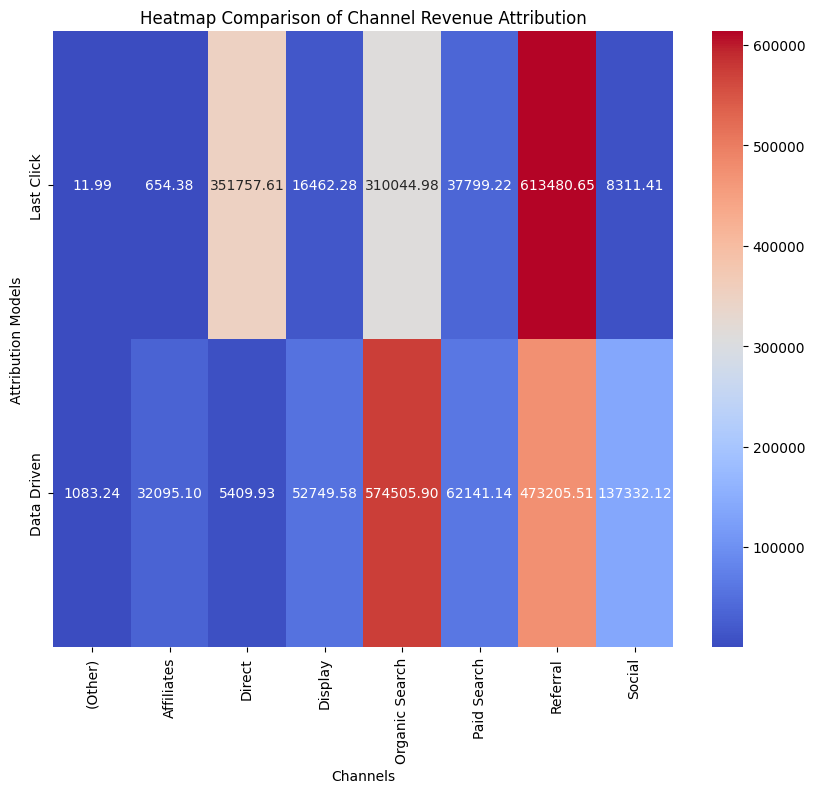

In [ ]:
import seaborn as sns

# Prepare data
comparison_heatmap = comparison.T

plt.figure(figsize=(10, 8))
sns.heatmap(comparison_heatmap, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Comparison of Channel Revenue Attribution')
plt.xlabel('Channels')
plt.ylabel('Attribution Models')
plt.show()
